In [1]:
import math
import numpy as np
import numpy
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import matplotlib.pyplot as plt
import urllib

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from skimage.measure import label, regionprops
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from multiprocessing import Pool, cpu_count
import community  # Louvain algorithm package

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

2023-07-21 20:42:32.847956: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 20:42:33.163485: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 20:42:34.917910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import os
from tqdm import tqdm

In [4]:
def tile(filename, dir_in, dir_out, d, image_or_mask):
    lst = []
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    grid = product(range(0, h - h % d, d), range(0, w - w % d, d))
    for i, j in grid:
        df = {}
        df[f'{image_or_mask}_name'] = filename
        df[f'{image_or_mask}_path'] = os.path.join(dir_in, filename)
        box = (j, i, j + d, i + d)
        out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        df[f'sliced_{image_or_mask}_path'] = out
        img.crop(box).save(out)
        lst.append(df)
    return lst

In [5]:
# create a function generate_sliced_images to generate sliced images from the original images and masks
def generate_sliced_images(image_df, d=256):
    data_dict = []

    if not os.path.isdir("data/sliced/image"):
        os.makedirs("data/sliced/image")
    if not os.path.isdir("data/sliced/bwmask"):
        os.makedirs("data/sliced/bwmask")

    with ThreadPoolExecutor() as executor:
        for image_data, mask_data in tqdm(zip(image_df['image'], image_df['bwmask']), total=len(image_df)):
            image_data = os.path.basename(image_data)
            mask_data = os.path.basename(mask_data)
            image_slices = executor.submit(tile, image_data, os.path.dirname(image_data), 'data/sliced/image', d, 'image')
            mask_slices = executor.submit(tile, mask_data, os.path.dirname(mask_data), 'data/sliced/bwmask', d, 'bwmask')
            image_slices = image_slices.result()
            mask_slices = mask_slices.result()

            merged_data = []
            for i in range(len(mask_slices)):
                mask_slices[i].update(image_slices[i])
                merged_data.extend(mask_slices)

            data_dict.extend(merged_data)

    return pd.DataFrame(data_dict)

##### Loading the data

In [6]:
def get_file_names(root_dir):
    image = []
    mask = []
    label= []
    for i in sorted(os.listdir(root_dir)):        
              for frame in sorted(os.listdir(path.join (root_dir,i))):
                  if i == 'bwmask':
                    mask.append(path.join (root_dir,i,frame))
                  elif i == 'label':
                    label.append(path.join(root_dir,i,frame))
                  else:
                    image.append(path.join(root_dir,i,frame))

    data_df = pd.DataFrame(data =(zip(image,mask,label)),columns = ['image','bwmask','label'])
    return data_df

#### Display the images per row

In [11]:
def strip_path(path):
    filename = os.path.basename(path)
    return filename


def display_images(row):
    image_path = row['image']
    bwmask_path = row['bwmask']
    label_path = row['label']

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    
    img1 = Image.open(image_path)
    imarray1 = numpy.array(img1)
    axs[0].imshow(img1)
    axs[0].set_title(strip_path(image_path))
    axs[0].axis('off')
    axs[0].text(0.5, -0.15, f'Shape: {imarray1.shape}', ha='center', transform=axs[0].transAxes)

    img2 = Image.open(bwmask_path)
    imarray2 = numpy.array(img2)
    axs[1].imshow(img2)
    axs[1].set_title(strip_path(bwmask_path))
    axs[1].axis('off')
    axs[1].text(0.5, -0.15, f'Shape: {imarray2.shape}', ha='center', transform=axs[1].transAxes)

    img3 = Image.open(label_path)
    imarray3 = numpy.array(img3)
    axs[2].imshow(img3)
    axs[2].set_title(strip_path(label_path))
    axs[2].axis('off')
    axs[2].text(0.5, -0.15, f'Shape: {imarray3.shape}', ha='center', transform=axs[2].transAxes)


    plt.tight_layout()

    plt.show()

In [12]:
image_df = get_file_names('data/')
image_df.tail(10)

,image,bwmask,label
43,data/image/ID319_A1_Regione-0.jp2-crop_slice_9...,data/bwmask/ID319_A1_Regione-0.jp2-crop_slice_...,data/label/ID319_A1_Regione-0.jp2-crop_slice_9...
44,data/image/ID319_A1_Regione-0.jp2-crop_slice_9...,data/bwmask/ID319_A1_Regione-0.jp2-crop_slice_...,data/label/ID319_A1_Regione-0.jp2-crop_slice_9...
45,data/image/ID319_A1_Regione-1.jp2-crop_slice_2...,data/bwmask/ID319_A1_Regione-1.jp2-crop_slice_...,data/label/ID319_A1_Regione-1.jp2-crop_slice_2...
46,data/image/ID319_A1_Regione-1.jp2-crop_slice_c...,data/bwmask/ID319_A1_Regione-1.jp2-crop_slice_...,data/label/ID319_A1_Regione-1.jp2-crop_slice_c...
47,data/image/ID319_A1_Regione-1.jp2-crop_slice_c...,data/bwmask/ID319_A1_Regione-1.jp2-crop_slice_...,data/label/ID319_A1_Regione-1.jp2-crop_slice_c...
48,data/image/ID319_A1_Regione-1.jp2-crop_slice_c...,data/bwmask/ID319_A1_Regione-1.jp2-crop_slice_...,data/label/ID319_A1_Regione-1.jp2-crop_slice_c...
49,data/image/ID343_A1b-3.jp2-crop_slice_18.png,data/bwmask/ID343_A1b-3.jp2-crop_slice_18.png,data/label/ID343_A1b-3.jp2-crop_slice_18.tif
50,data/image/ID343_A1b-3.jp2-crop_slice_6.png,data/bwmask/ID343_A1b-3.jp2-crop_slice_6.png,data/label/ID343_A1b-3.jp2-crop_slice_6.tif
51,data/image/ID343_A1b-3.jp2-crop_slice_7.png,data/bwmask/ID343_A1b-3.jp2-crop_slice_7.png,data/label/ID343_A1b-3.jp2-crop_slice_7.tif
52,data/image/ID4_A1_Regione-0-crop_slice_4.png,data/bwmask/ID4_A1_Regione-0-crop_slice_4.png,data/label/ID4_A1_Regione-0-crop_slice_4.tif


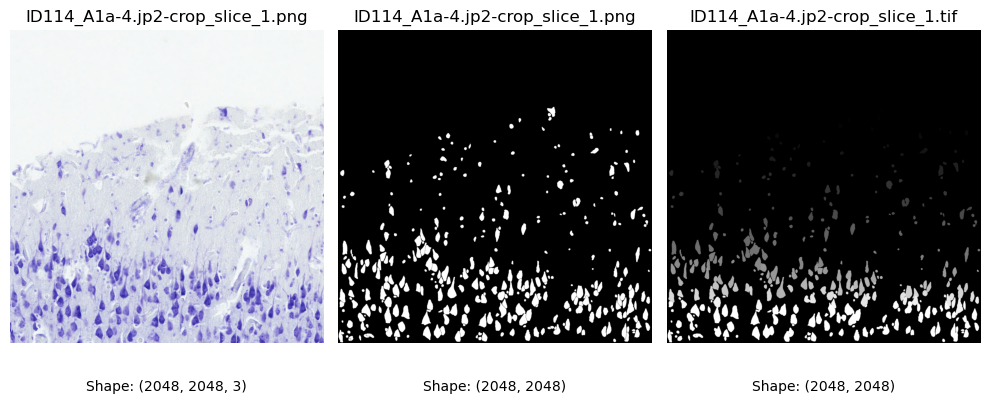

In [13]:
# Display images from the first row of the DataFrame
display_images(image_df.iloc[0])

In [14]:
def create_cell_network_graph(image_path, mask_path, min_area_threshold=100):
    # Generate sliced images and masks
    sliced_image_df = generate_sliced_images(image_df)

    # Process sliced_image_df to create the cell network graph
    cell_network_graph = nx.Graph()

    # Assuming sliced_image_df contains columns 'sliced_image_path' and 'area'
    for index, row in sliced_image_df.iterrows():
        node_name = row['sliced_image_path']  # Use the sliced image path as the node name
        area = row['area']  # Get the area attribute from the DataFrame

        # Add node to the graph with the 'area' attribute
        cell_network_graph.add_node(node_name, area=area)
    return cell_network_graph
